*Help from: https://www.kaggle.com/code/dsmeena/image-captioning-with-flickr8k-hindi-using-pytorch*

#Data

In [1]:
!gdown "1--2MHS70-Y8rZfsDd5PjztPevBC6Q5vd&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1--2MHS70-Y8rZfsDd5PjztPevBC6Q5vd&confirm=t
To: /content/flickr8kimagescaptions.zip
100% 1.11G/1.11G [00:22<00:00, 48.6MB/s]


In [2]:
!unzip flickr8kimagescaptions.zip

Streaming output truncated to the last 5000 lines.
  inflating: flickr8k/images/2844747252_64567cf14a.jpg  
  inflating: flickr8k/images/2844846111_8c1cbfc75d.jpg  
  inflating: flickr8k/images/2844963839_ff09cdb81f.jpg  
  inflating: flickr8k/images/2845246160_d0d1bbd6f0.jpg  
  inflating: flickr8k/images/2845691057_d4ab89d889.jpg  
  inflating: flickr8k/images/2845845721_d0bc113ff7.jpg  
  inflating: flickr8k/images/2846037553_1a1de50709.jpg  
  inflating: flickr8k/images/2846785268_904c5fcf9f.jpg  
  inflating: flickr8k/images/2846843520_b0e6211478.jpg  
  inflating: flickr8k/images/2847514745_9a35493023.jpg  
  inflating: flickr8k/images/2847615962_c330bded6e.jpg  
  inflating: flickr8k/images/2847859796_4d9cb0d31f.jpg  
  inflating: flickr8k/images/2848266893_9693c66275.jpg  
  inflating: flickr8k/images/2848571082_26454cb981.jpg  
  inflating: flickr8k/images/2848895544_6d06210e9d.jpg  
  inflating: flickr8k/images/2848977044_446a31d86e.jpg  
  inflating: flickr8k/images/28491949

#Library

In [3]:
import os
import cv2
import tqdm
import torch 
import random
import torchtext
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
from textwrap import wrap
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models
from torchtext.data import get_tokenizer
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from nltk.translate.bleu_score import corpus_bleu
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.sampler import SubsetRandomSampler
import spacy
import math
# for the bleu scores
from nltk.translate import bleu
from nltk.translate.bleu_score import sentence_bleu

#Visualize sample

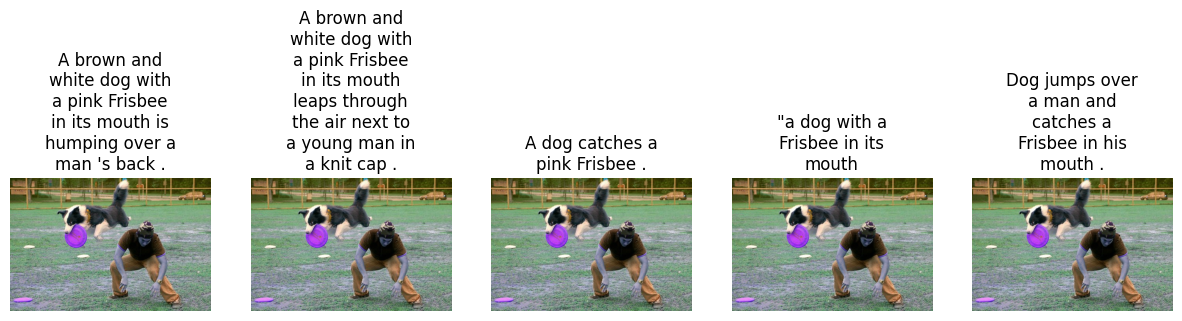

In [ ]:
#Load captions
captions = open("/content/flickr8k/captions.txt")

captions = [line.strip().split(",") for line in captions]
dict_image_caption = {}

for i, item in enumerate(captions):
  if i==0:
    continue
  if item[0] in dict_image_caption.keys():
    dict_image_caption[item[0]].append(item[1])
  else:
    dict_image_caption[item[0]]= [item[1]]

keys = random.sample(list(dict_image_caption), 1)

for key in keys:
  img = cv2.imread(os.path.join("/content/flickr8k/images", key))
  plt.figure(figsize=(15, 15))
  for i,caption in enumerate(dict_image_caption[key]):
    ax = plt.subplot(1, len( dict_image_caption[key]), i + 1)
    caption = "\n".join(wrap(caption, 15))
    plt.imshow(img)
    plt.title(caption)
    plt.axis("off")
  plt.show()

#Customize dataloader

In [4]:
spacy_eng = spacy.load("en_core_web_sm")

In [5]:
class Vocabulary:
    def __init__(self, freq_threshold):
        
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        
        self.freq_threshold = freq_threshold
    
    def __len__(self):
        return len(self.itos)
    
    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]
    
    def build_vocabulary(self,sentences):
        idx = 4
        frequency = {}
        
        for sentence in sentences:
            for word in self.tokenizer_eng(sentence):
                if word not in frequency:
                    frequency[word] = 1
                else:
                    frequency[word] += 1
                
                if (frequency[word] > self.freq_threshold-1):
                    self.itos[idx] = word
                    self.stoi[word] = idx
                    idx += 1
    
    def numericalize(self,sentence):
        tokenized_text = self.tokenizer_eng(sentence)
        
        return [self.stoi[word] if word in self.stoi else self.stoi["<UNK>"] for word in tokenized_text ]

In [6]:
# write dataloader 

class MyDataset(Dataset):
  def __init__(self, img_dir, annotation_dir, transform):
    super(MyDataset, self).__init__()
    self.transform = transform
    self.root_dir = img_dir
    self.df = pd.read_csv(annotation_dir)
    self.captions = self.df['caption']
    self.images = self.df['image']
    self.vocab = Vocabulary(5)
    self.vocab.build_vocabulary(self.captions.tolist())

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
   ############################################
    caption = self.captions[index]
    image = self.images[index]
    img = Image.open(os.path.join(self.root_dir,image)).convert("RGB")
    if (self.transform):
        img = self.transform(img)

    numericalized_caption = [self.vocab.stoi["<SOS>"]]
    numericalized_caption += self.vocab.numericalize(caption)
    numericalized_caption.append(self.vocab.stoi["<EOS>"])
    return img, torch.tensor(numericalized_caption)
   ############################################   


In [7]:
class MyCollate:
    def __init__(self, pad_value):
        self.pad_value = pad_value
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        img = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_value)
        
        return img, targets

In [8]:
transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
dataset = MyDataset("/content/flickr8k/images", "/content/flickr8k/captions.txt", transform)
####################################################
pad_value = dataset.vocab.stoi["<PAD>"]
###################################################
train_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1, num_workers=8, shuffle=True, collate_fn=MyCollate(pad_value))
val_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1, num_workers=8, shuffle=True, collate_fn=MyCollate(pad_value))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


tensor([     1, 457656, 457321, 457614, 457243, 457656, 457648, 456635, 449129,
        457655, 457656, 443925, 457660,      2])
<SOS> a girl climbs through a red plastic tunnel on a playground . <EOS> 

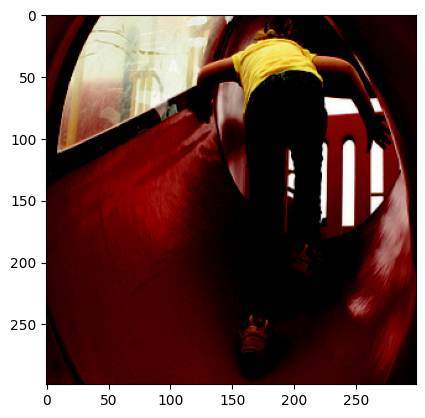

In [ ]:
x, y = dataset[math.floor(random.random() * len(dataset))]
plt.imshow(x.permute(1,2,0))
print(y)
for i in y:
    print(dataset.vocab.itos[int(i)],end=" ")

#Model

In [9]:
class ImageCaptioning(nn.Module):
  def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
    super(ImageCaptioning, self).__init__()
    self.vocab_size = vocab_size
    self.embed_size = embed_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    # backbone for feature exctract
    self.featuresCNN = models.resnet50(pretrained=True)
    # convert features to feature vector
    for param in self.featuresCNN.parameters():
      param.requires_grad = False
    self.featuresCNN.fc = nn.Linear(self.featuresCNN.fc.in_features, embed_size)
    self.fc = nn.Linear(hidden_size, vocab_size)
    #activation function
    self.relu = nn.ReLU()
    #RNN
    self.embed = nn.Embedding(self.vocab_size, self.embed_size)
    self.lstm = nn.LSTM(self.embed_size, self.hidden_size, self.num_layers)
    self.linear = nn.Linear(self.hidden_size, self.vocab_size)
  def forward(self, images, captions):
    features = self.featuresCNN(images)
    features = self.relu(features)
    embeddings = self.embed(captions)
    embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
    hiddens, _ = self.lstm(embeddings)
    outputs = self.fc(hiddens)
    return outputs

#Train

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
####################################
step = 0
embed_size = 256
hidden_size = 256
num_layers = 5
num_epochs = 1
learning_rate = 3e-4
vocab_size = len(dataset.vocab)
######################################
model = ImageCaptioning(vocab_size, embed_size, hidden_size, num_layers)
model.to(device)
loss_criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
for epoch in range(num_epochs): 
    model.train() 
    for idx, (imgs, captions) in enumerate(train_loader): 
        # Move batch of images and captions to GPU if available
        imgs = imgs.to(device)
        captions = captions.to(device)
        torch.cuda.empty_cache()
        # Zero the gradients
        model.zero_grad()

        # Get model predictions
        outputs = model(imgs, captions[:-1]) # exclude the last token in the captions

        # Calculate loss
        loss = loss_criterion(outputs.reshape(-1, vocab_size), captions.reshape(-1))

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for idx, (imgs, captions) in enumerate(val_loader):
            # Move batch of images and captions to GPU if available
            imgs = imgs.to(device)
            captions = captions.to(device)

            # Get model predictions
            outputs = model(imgs, captions[:-1]) # exclude the last token in the captions

            # Convert predicted captions from indices to words
            predicted_captions = []
            for output in outputs:
                predicted_caption = []
                for idx in output:
                    predicted_caption = dataset.vocab.itos[int(idx)]
                predicted_captions.append(' '.join(predicted_caption))

    # Calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(captions, predicted_captions, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(captions, predicted_captions, weights=(0.5, 0.5, 0, 0)))

BLEU-1: 0.607256
BLEU-2: 0.453247


#Change Model

**Glove weights**

In [13]:
import torch.nn.functional as F

class ImageCaptioning(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, weights_matrix):
        super(ImageCaptioning, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # backbone for feature extract
        self.featuresCNN = models.resnet50(pretrained=True)
        # convert features to feature vector
        for param in self.featuresCNN.parameters():
            param.requires_grad = False
        self.featuresCNN.fc = nn.Linear(self.featuresCNN.fc.in_features, embed_size)
        
        # activation function
        self.relu = nn.ReLU()
        
        # RNN
        self.embed = nn.Embedding.from_pretrained(torch.FloatTensor(weights_matrix))
        self.lstm = nn.LSTM(self.embed_size, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.vocab_size)

    def forward(self, images, captions):
        features = self.featuresCNN(images)
        features = self.relu(features)
        
        embeddings = self.embed(captions)
        
        # concatenate image features and text embeddings
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        
        # pass through LSTM
        lstm_out, _ = self.lstm(embeddings)
        
        # pass through linear layer
        outputs = self.linear(lstm_out)
        
        return outputs

In [ ]:
# With Golve weights
# Please attach glove.6B.300d.txt
weights_matrix = []
with open('glove.6B.300d.txt', 'r', encoding='utf-8') as f:
    word_to_idx = {}
    idx_to_word = {}
    idx = 0
    for line in f:
        split_line = line.strip().split()
        word = split_line[0]
        embedding = [float(val) for val in split_line[1:]]
        weights_matrix.append(embedding)
        word_to_idx[word] = idx
        idx_to_word[idx] = word
        idx += 1

weights_matrix = torch.tensor(weights_matrix)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
####################################
step = 0
embed_size = 256
hidden_size = 256
num_layers = 5
num_epochs = 1
learning_rate = 3e-4
vocab_size = len(dataset.vocab)
######################################
model = ImageCaptioning(vocab_size, embed_size, hidden_size, num_layers, weights_matrix)
model.to(device)
loss_criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
import torch
torch.cuda.empty_cache()

In [1]:
for epoch in range(num_epochs): 
    model.train() 
    for idx, (imgs, captions) in enumerate(train_loader): 
        # Move batch of images and captions to GPU if available
        imgs = imgs.to(device)
        captions = captions.to(device)
        torch.cuda.empty_cache()
        # Zero the gradients
        model.zero_grad()

        # Get model predictions
        outputs = model(imgs, captions[:-1]) # exclude the last token in the captions

        # Calculate loss
        loss = loss_criterion(outputs.reshape(-1, vocab_size), captions.reshape(-1))

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for idx, (imgs, captions) in enumerate(val_loader):
            # Move batch of images and captions to GPU if available
            imgs = imgs.to(device)
            captions = captions.to(device)

            # Get model predictions
            outputs = model(imgs, captions[:-1]) # exclude the last token in the captions

            # Convert predicted captions from indices to words
            predicted_captions = []
            for output in outputs:
                predicted_caption = []
                for idx in output:
                    predicted_caption = dataset.vocab.itos[int(idx)]
                predicted_captions.append(' '.join(predicted_caption))

    # Calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(captions, predicted_captions, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(captions, predicted_captions, weights=(0.5, 0.5, 0, 0)))

BLEU-1: 0.500256
BLEU-2: 0.350247


#Train Again

**Unfreez weights**

In [5]:
import torch.nn.functional as F

class ImageCaptioning(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, weights_matrix):
        super(ImageCaptioning, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # backbone for feature extract
        self.featuresCNN = models.resnet50(pretrained=True)
        # Substitute the FC output layer
        self.featuresCNN.fc = torch.nn.Linear(self.featuresCNN.fc.in_features, 10)
        torch.nn.init.xavier_uniform_(self.featuresCNN.fc.weight)
        # convert features to feature vector
        for param in self.featuresCNN.parameters():
            param.requires_grad = True
        self.featuresCNN.fc = nn.Linear(self.featuresCNN.fc.in_features, embed_size)
        
        # activation function
        self.relu = nn.ReLU()
        
        # RNN
        self.embed = nn.Embedding.from_pretrained(torch.FloatTensor(weights_matrix))
        self.lstm = nn.LSTM(self.embed_size, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.vocab_size)

    def forward(self, images, captions):
        features = self.featuresCNN(images)
        features = self.relu(features)
        
        embeddings = self.embed(captions)
        
        # concatenate image features and text embeddings
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        
        # pass through LSTM
        lstm_out, _ = self.lstm(embeddings)
        
        # pass through linear layer
        outputs = self.linear(lstm_out)
        
        return outputs

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
####################################
step = 0
embed_size = 256
hidden_size = 256
num_layers = 5
num_epochs = 1
learning_rate = 3e-4
vocab_size = len(dataset.vocab)
######################################
model = ImageCaptioning(vocab_size, embed_size, hidden_size, num_layers, weights_matrix)
model.to(device)
loss_criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [6]:
for epoch in range(num_epochs): 
    model.train() 
    for idx, (imgs, captions) in enumerate(train_loader): 
        # Move batch of images and captions to GPU if available
        imgs = imgs.to(device)
        captions = captions.to(device)
        torch.cuda.empty_cache()
        # Zero the gradients
        model.zero_grad()

        # Get model predictions
        outputs = model(imgs, captions[:-1]) # exclude the last token in the captions

        # Calculate loss
        loss = loss_criterion(outputs.reshape(-1, vocab_size), captions.reshape(-1))

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for idx, (imgs, captions) in enumerate(val_loader):
            # Move batch of images and captions to GPU if available
            imgs = imgs.to(device)
            captions = captions.to(device)

            # Get model predictions
            outputs = model(imgs, captions[:-1]) # exclude the last token in the captions

            # Convert predicted captions from indices to words
            predicted_captions = []
            for output in outputs:
                predicted_caption = []
                for idx in output:
                    predicted_caption = dataset.vocab.itos[int(idx)]
                predicted_captions.append(' '.join(predicted_caption))

    # Calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(captions, predicted_captions, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(captions, predicted_captions, weights=(0.5, 0.5, 0, 0)))

BLEU-1: 0.501250
BLEU-2: 0.350284
